# EDA PAGAMENTOS

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, min, max, avg, countDistinct,
    lit, to_timestamp, date_format, trunc, datediff, last_day, to_date
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import DecimalType
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 4, Finished, Available, Finished)

# 1. Leitura e Exploração dos Dados

In [3]:
df_pagamentos = spark.sql("SELECT * FROM Silver.rawdata.pagamento")
display(df_pagamentos)

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, dc7d3d6c-922a-4190-a25c-7a4f4a2fa663)

In [3]:
# Leitura da tab forma_pagamento
df_forma_pagamentos = spark.sql("SELECT * FROM Silver.rawdata.forma_pagamento")
display(df_forma_pagamentos)

StatementMeta(, , -1, Waiting, , Waiting)

In [4]:
# Visualizando as colunas da base
df_pagamentos.printSchema()

StatementMeta(, e80a482a-d7ae-472f-bd2c-7c91529a295b, 7, Finished, Available, Finished)

root
 |-- SEQ_ARQUIVO_PAGAMENTO: long (nullable = true)
 |-- NUM_PARCELA_PAGAMENTO: long (nullable = true)
 |-- NUM_AGRUPADOR_PAGAMENTO: string (nullable = true)
 |-- DSC_PAGAMENTO: string (nullable = true)
 |-- VAL_ATUAL_PAGAMENTO: decimal(18,4) (nullable = true)
 |-- COD_METODO_PAGAMENTO: long (nullable = true)
 |-- IND_STATUS_PAGAMENTO: string (nullable = true)
 |-- DAT_STATUS_PAGAMENTO: timestamp (nullable = true)
 |-- COD_ARQUIVO_PAGAMENTO: string (nullable = true)
 |-- COD_NETUNO_PAGAMENTO: string (nullable = true)
 |-- DAT_CRIACAO_CREDITO: timestamp (nullable = true)
 |-- DAT_ATUALIZACAO_CREDITO: timestamp (nullable = true)
 |-- COD_LOGIN_CREDITO: string (nullable = true)
 |-- VAL_PAGAMENTO_CREDITO: decimal(18,4) (nullable = true)
 |-- IND_TIPO_CREDITO: string (nullable = true)
 |-- SEQ_PAGAMENTO_CREDITO: long (nullable = true)
 |-- SEQ_FATURA_CREDITO: long (nullable = true)
 |-- COD_ALOCACAO_CREDITO: string (nullable = true)
 |-- COD_DESALOCACAO_CREDITO: string (nullable = true

In [5]:
# Função para gerar metadados da base
def gerar_meta_dados(df):
    """
    Gera um DataFrame de metadados de um Dataframe fornecidoo.
    return: Dataframe contendo os metadados
    """
    total_rows = df.count()
    metadata = []

    for col_name, col_type in df.dtypes:
        nulos = df.filter(F.col(col_name).isNull()).count()
        cardinalidade = df.select(col_name).distinct().count()
        perct_nulos = round((nulos / total_rows) * 100, 2) if total_rows > 0 else 0

        metadata.append((
            col_name,
            col_type,
            nulos,
            perct_nulos,
            cardinalidade
        ))

    return df.sparkSession.createDataFrame(
        metadata,
        ["coluna", "tipo_de_dados", "nulos", "percent_nulos", "cardinalidade" ]
    )

StatementMeta(, e80a482a-d7ae-472f-bd2c-7c91529a295b, 8, Finished, Available, Finished)

In [6]:
# Visualizando os metadados da base
df_metadados = gerar_meta_dados(df_pagamentos)

# Colocando em ordem decrescente correspondente ao % de nulos.
df_metadados.orderBy(F.col("percent_nulos").desc()).show(df_metadados.count(), False)

StatementMeta(, e80a482a-d7ae-472f-bd2c-7c91529a295b, 9, Finished, Available, Finished)

+----------------------------+-------------+--------+-------------+-------------+
|coluna                      |tipo_de_dados|nulos   |percent_nulos|cardinalidade|
+----------------------------+-------------+--------+-------------+-------------+
|COD_DESALOCACAO_CREDITO     |string       |27948583|100.0        |1            |
|COD_NETUNO_PAGAMENTO        |string       |27948583|100.0        |1            |
|DAT_ATUALIZACAO_CREDITO     |timestamp    |27948583|100.0        |1            |
|COD_FUNDO_ATIVIDADE         |string       |27937991|99.96        |1479         |
|NUM_PARCELA_PAGAMENTO       |bigint       |27387166|97.99        |653          |
|DAT_ATUALIZACAO_ATIVIDADE   |timestamp    |26849785|96.07        |394599       |
|NUM_CONTA_ATIVIDADE         |string       |25621463|91.67        |272211       |
|DAT_ATUALIZACAO_PAGAMENTO   |timestamp    |25001438|89.46        |185328       |
|DSC_PAGAMENTO               |string       |24967432|89.33        |1959589      |
|COD_ARQUIVO_PAG

In [7]:
# Verificando os valores distintos de atributos com baixa cardinalidade (igual ou menor que 5)
df_metadados_baixa_card = (
    df_metadados
    .filter(
        (F.col("cardinalidade") <= 5) &
        (F.col("percent_nulos") < 100)
        )
    .select("coluna", "cardinalidade")
)

colunas_baixa_card = [row["coluna"] for row in df_metadados_baixa_card.collect()]

for col_name in colunas_baixa_card:
    print(f"\nColuna: {col_name}")
    df_pagamentos.select(col_name).distinct().show(truncate=False)

StatementMeta(, , -1, Waiting, , Waiting)

# 2. Análises

## Análisando as Colunas de Data

In [13]:
cols_datas = [c for c in df_pagamentos.columns if c.startswith("DAT_")]
cols_datas

StatementMeta(, e80a482a-d7ae-472f-bd2c-7c91529a295b, 10, Finished, Available, Finished)

['DAT_STATUS_PAGAMENTO',
 'DAT_CRIACAO_CREDITO',
 'DAT_ATUALIZACAO_CREDITO',
 'DAT_ATIVIDADE_CREDITO',
 'DAT_VENCIMENTO_CREDITO',
 'DAT_STATUS_FATURA',
 'DAT_CRIACAO_DW',
 'DAT_CRIACAO_ATIVIDADE',
 'DAT_ATUALIZACAO_ATIVIDADE',
 'DAT_BAIXA_ATIVIDADE',
 'DAT_DEPOSITO_ATIVIDADE',
 'DAT_CRIACAO_PAGAMENTO',
 'DAT_ATUALIZACAO_PAGAMENTO']

In [5]:
# Criação da variável "SAFRA"
df_pagamentos = df_pagamentos.withColumn(
    "SAFRA",
    date_format(col("DAT_STATUS_FATURA"), "yyyyMM")
)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 7, Finished, Available, Finished)

### Verificação das colunas `DAT_CRIACAO_CREDITO`, `DAT_STATUS_FATURA` e `DAT_CRIACAO_PAGAMENTO`

In [31]:
df_datas = (
    df_pagamentos
    .withColumn("DT_CRIACAO_CREDITO", to_date(col("DAT_CRIACAO_CREDITO")))
    .withColumn("DT_STATUS_FATURA", to_date(col("DAT_STATUS_FATURA")))
    .withColumn("DT_CRIACAO_PAGAMENTO", to_date(col("DAT_CRIACAO_PAGAMENTO")))
)

df_comparacao = (
    df_datas
    .withColumn(
        "CRIACAO_CREDITO_EQ_STATUS_FATURA",
        when(col("DT_CRIACAO_CREDITO") == col("DT_STATUS_FATURA"), 1).otherwise(0)
    )
    .withColumn(
        "CRIACAO_CREDITO_EQ_CRIACAO_PAGAMENTO",
        when(col("DT_CRIACAO_CREDITO") == col("DT_CRIACAO_PAGAMENTO"), 1).otherwise(0)
    )
    .withColumn(
        "STATUS_FATURA_EQ_CRIACAO_PAGAMENTO",
        when(col("DT_STATUS_FATURA") == col("DT_CRIACAO_PAGAMENTO"), 1).otherwise(0)
    )
)

StatementMeta(, , -1, Waiting, , Waiting)

In [14]:
df_resultado = (
    df_comparacao
    .groupBy(
        "CRIACAO_CREDITO_EQ_STATUS_FATURA",
        "CRIACAO_CREDITO_EQ_CRIACAO_PAGAMENTO",
        "STATUS_FATURA_EQ_CRIACAO_PAGAMENTO"
    )
    .count()
    .orderBy("count", ascending=False)
)

df_resultado.show(truncate=False)


In [32]:
df_comparacao.select(
    "DAT_CRIACAO_CREDITO",
    "DAT_VENCIMENTO_CREDITO",
    "DAT_STATUS_FATURA",
    "DAT_CRIACAO_PAGAMENTO",
    "CRIACAO_CREDITO_EQ_STATUS_FATURA",
    "CRIACAO_CREDITO_EQ_CRIACAO_PAGAMENTO",
    "STATUS_FATURA_EQ_CRIACAO_PAGAMENTO"
).show(20, truncate=False)


In [17]:
df_datas_validas = df_datas.filter(
    col("DT_CRIACAO_CREDITO").isNotNull() &
    col("DT_STATUS_FATURA").isNotNull() &
    col("DT_CRIACAO_PAGAMENTO").isNotNull()
)

df_comparacao_notnull = (
    df_datas_validas
    .withColumn(
        "CRIACAO_CREDITO_EQ_STATUS_FATURA",
        when(col("DT_CRIACAO_CREDITO") == col("DT_STATUS_FATURA"), 1).otherwise(0)
    )
    .withColumn(
        "CRIACAO_CREDITO_EQ_CRIACAO_PAGAMENTO",
        when(col("DT_CRIACAO_CREDITO") == col("DT_CRIACAO_PAGAMENTO"), 1).otherwise(0)
    )
    .withColumn(
        "STATUS_FATURA_EQ_CRIACAO_PAGAMENTO",
        when(col("DT_STATUS_FATURA") == col("DT_CRIACAO_PAGAMENTO"), 1).otherwise(0)
    )
)

In [18]:
df_resultado = (
    df_comparacao_notnull
    .groupBy(
        "CRIACAO_CREDITO_EQ_STATUS_FATURA",
        "CRIACAO_CREDITO_EQ_CRIACAO_PAGAMENTO",
        "STATUS_FATURA_EQ_CRIACAO_PAGAMENTO"
    )
    .count()
    .orderBy("count", ascending=False)
)

df_resultado.show(truncate=False)

In [34]:
df_null_analysis = (
    df_datas
    .withColumn(
        "CREDITO_PREENCHIDO",
        when(col("DAT_CRIACAO_CREDITO").isNotNull(), 1).otherwise(0)
    )
    .withColumn(
        "PAGAMENTO_PREENCHIDO",
        when(col("DAT_CRIACAO_PAGAMENTO").isNotNull(), 1).otherwise(0)
    )
    .groupBy("CREDITO_PREENCHIDO", "PAGAMENTO_PREENCHIDO")
    .count()
)

df_null_analysis.show()

In [34]:
df_null_analysis_2 = (
    df_datas
    .withColumn(
        "CREDITO_PREENCHIDO",
        when(col("DAT_CRIACAO_CREDITO").isNotNull(), 1).otherwise(0)
    )
    .withColumn(
        "VENCIMENTO_PREENCHIDO",
        when(col("DAT_VENCIMENTO_CREDITO").isNotNull(), 1).otherwise(0)
    )
    .groupBy("CREDITO_PREENCHIDO", "VENCIMENTO_PREENCHIDO")
    .count()
)

df_null_analysis_2.show()

In [42]:
# Confirmando as 4 possíveis combinações.
combinacoes = spark.createDataFrame(
    [(0,0), (0,1), (1,0), (1,1)],
    ["CREDITO_PREENCHIDO", "PAGAMENTO_PREENCHIDO"]
)

combinacoes.join(
    df_null_analysis,
    ["CREDITO_PREENCHIDO", "PAGAMENTO_PREENCHIDO"],
    "left"
).fillna(0).show()

In [9]:

total = df_pagamentos.count()

nulos = (
    df_pagamentos
    .filter(col("DAT_STATUS_FATURA").isNull())
    .count()
)

print(f"Total de Registros: {total}")
print(f"O Total de Nulos é de: {nulos}")

### **Análise das Data**

### Objetivo
Avaliar se as colunas de datas disponíveis representam de forma confiável o **comportamento real de pagamento do cliente** ao longo do tempo.

---

### Datas Avaliadas
- `DAT_CRIACAO_CREDITO`
- `DAT_STATUS_FATURA`
- `DAT_CRIACAO_PAGAMENTO`
---

### Principais Análises Realizadas

#### 1. Comparação entre datas de criação, status e pagamento
- Inicialmente comparadas como *timestamp* (data + hora)
- Ajuste para comparação **somente da data**, devido a:
  - `DAT_STATUS_FATURA` possuir horário fixo `00:00:00`
- Resultado:
  - **Alta coincidência entre as três datas**
  - A maioria dos registros apresenta as três datas iguais

#### 2. Análise de nulos
- Identificamos:
  - ~12 milhões de registros com `DAT_CRIACAO_PAGAMENTO` nulo.
  - As colunas `DAT_CRIACAO_CREDITO` `DAT_VENCIMENTO_CREDITO` e `DAT_CRIACAO_PAGAMENTO` compartilham o mesmo padrão de preenchimento (ambas nulas ou ambas preenchidas).
- **Descoberta importante**:
  - `DAT_STATUS_FATURA` **não possui valores nulos** (100% preenchida).

#### 3. Análise de preenchimento entre datas
- Comparação entre:
  - `DAT_CRIACAO_CREDITO`
  - `DAT_CRIACAO_PAGAMENTO`
  - `DAT_STATUS_FATURA`
- Resultado:
  - Preenchimento **totalmente correlacionado**
---
### Conclusão Final
- As datas:
  - `DAT_CRIACAO_CREDITO`
  - `DAT_CRIACAO_PAGAMENTO`
  
  representam **eventos sistêmicos/operacionais**, não o comportamento do cliente.


## Análise temporal de registro

In [21]:
# Isolar um CPF específico para análise
cpf_teste = "7778YW7Y7ZU"

df_cpf_timeline = (
    df_pagamentos
    .filter(f"""
    NUM_CPF = '{cpf_teste}'
    """)
    .select(
        "NUM_CPF",
        "DAT_CRIACAO_CREDITO",
        "DAT_VENCIMENTO_CREDITO",
        "CONTRATO",
        "IND_STATUS_FATURA",
        "VAL_PAGAMENTO_FATURA",
        "SEQ_FATURA",
        "DAT_STATUS_FATURA",
        "DAT_CRIACAO_PAGAMENTO",
        "DAT_ATUALIZACAO_PAGAMENTO",
        "DW_FORMA_PAGAMENTO",
        "DAT_CRIACAO_DW"
    )
    .orderBy("SEQ_FATURA")
)

df_cpf_timeline.show(50, truncate=False)

In [20]:
# Analisar por CPF e CONTRATO específico.
cpf_teste = "7777XZTYTN8"

df_cpf_timeline = (
    df_pagamentos
    .filter(f"""
    NUM_CPF = '{cpf_teste}'
    AND DAT_CRIACAO_PAGAMENTO IS NOT NULL
    AND CONTRATO = "871865223"
    """)
    .select(
        "NUM_CPF",
        "DAT_CRIACAO_CREDITO",
        "DAT_VENCIMENTO_CREDITO",
        "CONTRATO",
        "VAL_PAGAMENTO_FATURA",
        "SEQ_FATURA", 
        "IND_STATUS_FATURA",
        "DAT_CRIACAO_PAGAMENTO",
        "DAT_ATUALIZACAO_PAGAMENTO",
        "DW_FORMA_PAGAMENTO"
    )
    .orderBy("SEQ_FATURA")
)

df_cpf_timeline.show(500, truncate=False)

In [5]:
# Identificando os 10 cpfs com maiores quantidades de registros
df_cpf = (
    df_pagamentos
    .groupBy("NUM_CPF")
    .agg(count("*").alias("qtd_registros"))
    .filter("qtd_registros >= 10")
    .orderBy("qtd_registros", ascending=False)
)

df_cpf.show(10)

## Análise da Coluna `DAT_STATUS_FATURA`

In [8]:
# Verificando quantidade de CPFS distintos
df_pagamentos.select(
    countDistinct("NUM_CPF").alias("qtd_cpfs"),
).show()

# Verificando quantidade de registros
print("Total de registros:", df_pagamentos.count())

In [41]:
# Distribuição Temporal (por mês de vencimento)
df_pagamentos\
    .withColumn("dt_fatura", to_date("DAT_STATUS_FATURA"))\
    .withColumn("mes_fatura", trunc("dt_fatura", "month"))\
    .groupBy("mes_fatura")\
    .count()\
    .orderBy("mes_fatura")\
    .show(500)

In [42]:
# CPFs por mês

df_pagamentos\
    .withColumn("dt_fatura", to_date("DAT_STATUS_FATURA"))\
    .withColumn("mes_fatura", trunc("dt_fatura", "month"))\
    .groupBy("mes_fatura")\
    .agg(countDistinct("NUM_CPF").alias("cpfs_ativos"))\
    .orderBy("mes_fatura")\
    .show(500)

In [43]:
# Comparação Dentro vs Fora da Safra

df_flag_safra = df_pagamentos.withColumn(
    "flag_safra",
    when(
        (col("DAT_STATUS_FATURA") >= "2024-10-01") &
        (col("DAT_STATUS_FATURA") <= "2025-03-31"),
        "DENTRO_SAFRA"
    ).otherwise("FORA_SAFRA")
)

df_flag_safra.groupBy("flag_safra").agg(
    countDistinct("NUM_CPF").alias("qtd_cpfs"),
    spark_sum("VAL_PAGAMENTO_FATURA").alias("valor_total")
).show()

In [3]:
# Verificando a quantidade de registros distintos para IND_STATUS_FATURA
df_pagamentos.groupby("IND_STATUS_FATURA").count().show()

In [4]:
# Verificando para o status 'C', a data de status coincide com a data de criação do pagamento.

df_validacao_status = (
    df_pagamentos
    .filter(col("IND_STATUS_FATURA") == "C")
.withColumn(
    "STATUS_EQ_CRIACAO_PAGAMENTO",
    when(
        to_date(col("DAT_STATUS_FATURA")) == to_date(col("DAT_CRIACAO_PAGAMENTO")),
        1
    ).otherwise(0)
)
.groupby("STATUS_EQ_CRIACAO_PAGAMENTO")
.count()
)

df_validacao_status.show()

**Insights:**

- ``DAT_STATUS_FATURA`` é a data de referência do pagamento

- ``DAT_CRIACAO_PAGAMENTO`` é uma data operacional

- As duas coincidirem em ~56% dos casos é até um número alto

- O fato de divergirem em ~44% reforça que ``DAT_STATUS_FATURA`` é a data correta para análise comportamental

In [17]:
# Criando a Query para validar a quantidade de dias entre DAT_STATUS_FATURA e DAT_VENCIMENTO_CREDITO
df_atrasos = (
    df_pagamentos
    .filter((col("IND_STATUS_FATURA") == "C"))
    .withColumn(
        "DIAS_ATRASO",
        datediff(
            to_date(col("DAT_STATUS_FATURA")),
            to_date(col("DAT_VENCIMENTO_CREDITO"))
        ) 
    )
)

In [18]:
# Olhando as estatísticas em relação aos dias de diferença
df_atrasos.select("DIAS_ATRASO").summary().show()

In [13]:
# Conferência Manual (Amostra)
df_atrasos\
    .filter(col("DAT_VENCIMENTO_CREDITO").isNotNull())\
    .select(
    "NUM_CPF",
    "CONTRATO",
    "DAT_VENCIMENTO_CREDITO",
    "DAT_STATUS_FATURA",
    "IND_STATUS_FATURA",
    "DIAS_ATRASO"
).orderBy(col("DIAS_ATRASO").desc()).show(20, truncate=False)

## Análise de Colunas Decimais

In [65]:
# Selecionando as colunas decimais
colunas_decimais = [
    field.name
    for field in df_pagamentos.schema.fields
    if isinstance(field.dataType, (DecimalType))
]


colunas_decimais

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 67, Finished, Available, Finished)

['VAL_ATUAL_PAGAMENTO',
 'VAL_PAGAMENTO_CREDITO',
 'VAL_PAGAMENTO_FATURA',
 'VAL_DESCONTO_ITEM',
 'VAL_PAGAMENTO_ITEM',
 'VAL_JUROS_MULTAS_ITEM',
 'VAL_MULTA_EQUIP_ITEM',
 'VAL_MULTA_EQUIP_TOTAL',
 'VAL_MULTA_FID_ITEM',
 'VAL_BAIXA_ATIVIDADE',
 'VAL_ORIGINAL_PAGAMENTO']

In [66]:
# Análise do min, max e média das colunas de valores
medidas_colunas_decimais = (
    df_pagamentos
    .select([
        min(col(c)).alias(f"{c}_min") for c in colunas_decimais
    ] + [
        max(col(c)).alias(f"{c}_max") for c in colunas_decimais
    ] + [
        avg(col(c)).alias(f"{c}_avg") for c in colunas_decimais
    ])
)

display(medidas_colunas_decimais)

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 68, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d79e3c07-d0f1-44d4-8111-e0c8e05fa48d)

In [67]:
def boxplot_coluna(df, coluna, sample_frac=0.05):
    df_plot = (
        df
        .select(col(coluna).cast("double").alias(coluna))
        .where(col(coluna).isNotNull())
        .sample(fraction=sample_frac, seed=42)
    )

    valores = df_plot.toPandas()[coluna]

    plt.figure(figsize=(6, 4))
    plt.boxplot(valores)
    plt.title(coluna)
    plt.show()


StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 69, Finished, Available, Finished)

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 70, Finished, Available, Finished)

Analisando coluna: VAL_ATUAL_PAGAMENTO


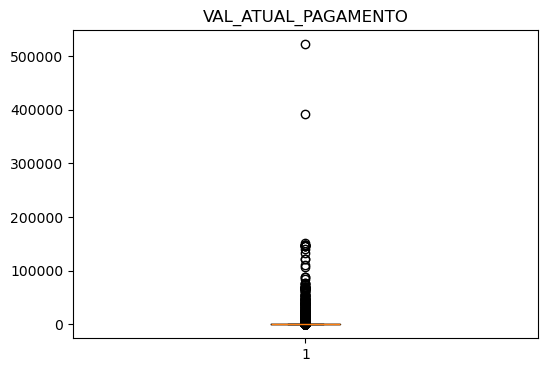

Analisando coluna: VAL_PAGAMENTO_CREDITO


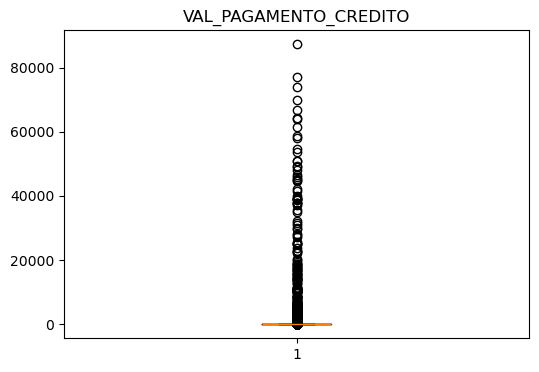

Analisando coluna: VAL_PAGAMENTO_FATURA


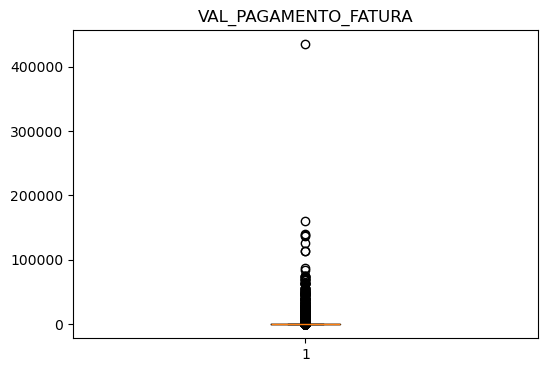

Analisando coluna: VAL_DESCONTO_ITEM


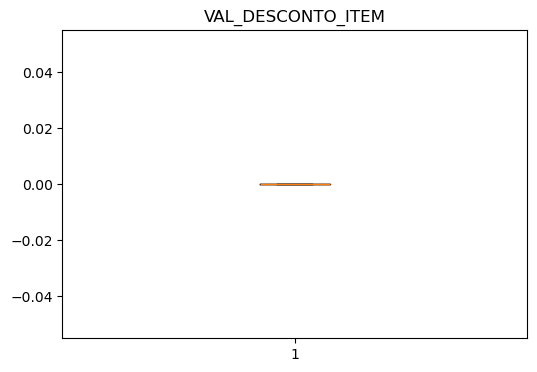

Analisando coluna: VAL_PAGAMENTO_ITEM


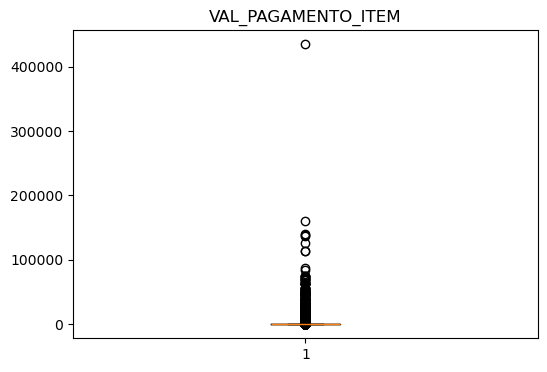

Analisando coluna: VAL_JUROS_MULTAS_ITEM


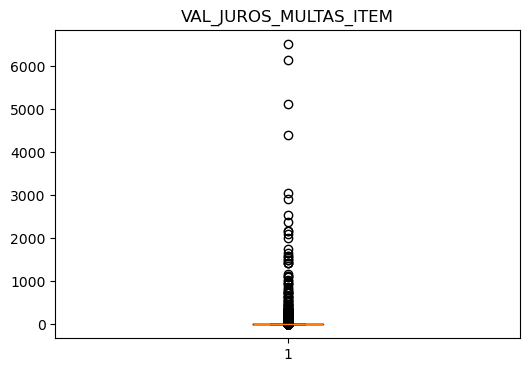

Analisando coluna: VAL_MULTA_EQUIP_ITEM


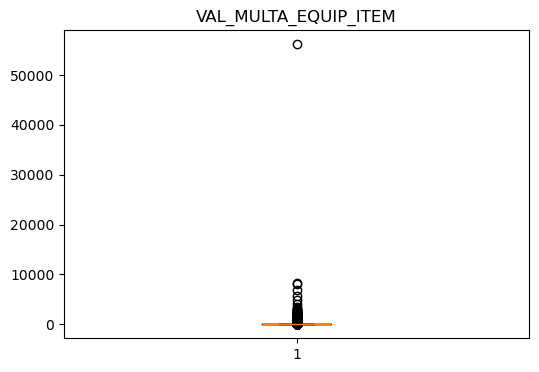

Analisando coluna: VAL_MULTA_EQUIP_TOTAL


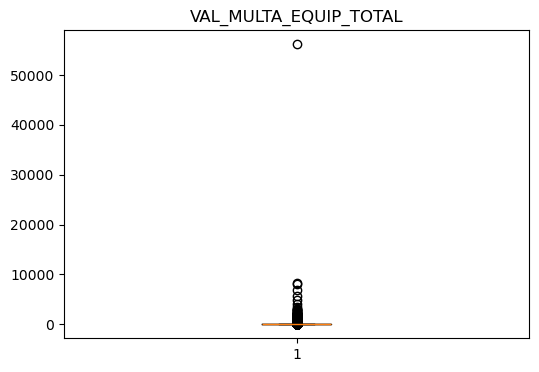

Analisando coluna: VAL_MULTA_FID_ITEM


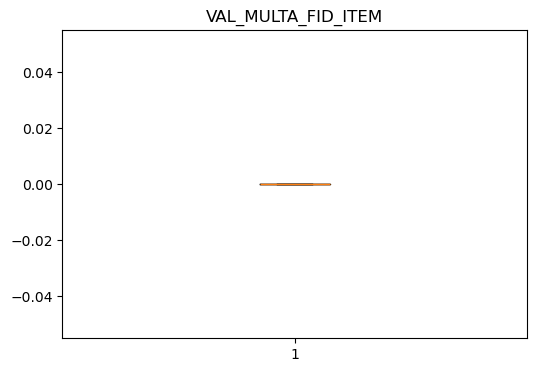

Analisando coluna: VAL_BAIXA_ATIVIDADE


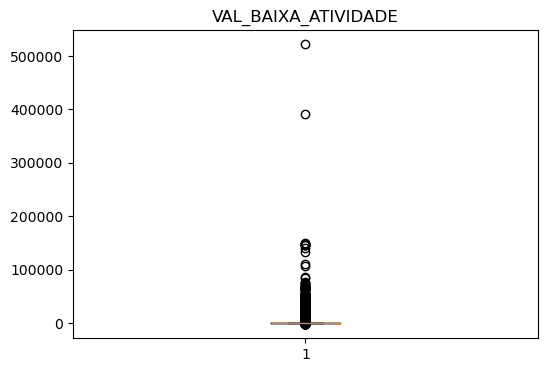

Analisando coluna: VAL_ORIGINAL_PAGAMENTO


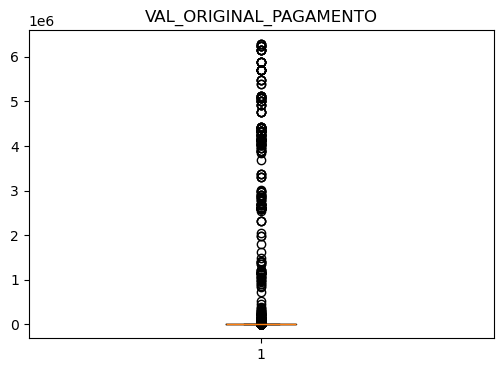

In [68]:
for coluna in colunas_decimais:
    print(f"Analisando coluna: {coluna}")
    boxplot_coluna(df_pagamentos, coluna)

# BOOK_COMPORTAMENTAL por SAFRA

## **Estrutura do BOOK V1**

**O BOOK V1** (Book Comportamental) tem como objetivo consolidar, em nível de contrato e cliente, o comportamento de pagamento ao longo do tempo, permitindo análises de:

- Safra

- Atraso

- Regularidade de pagamento

- Evolução comportamental

- Base para modelos preditivos (ex: inadimplência, churn, risco)

Este book é uma camada analítica, derivada de dados operacionais já tratados

**Chaves:**
- NUM_CPF
- SAFRA (derivada da data)
- Variáveis comportamentais
- Quantidade de pagamentos

**Média de dias de atraso:**
- Percentual de pagamentos em atraso
- Flags de atraso
- Buckets de atraso

## 1. Seleção e Limpeza da Base

In [28]:
# Criando o DF com as principais variáveis
df_base = (
    df_pagamentos
    .filter(col("IND_STATUS_FATURA") == "C")
    .filter(col("DAT_VENCIMENTO_CREDITO").isNotNull())  # Retirando os NULLS de DAT_VENCIMENTO_CREDITO
    .select(
        "NUM_CPF",
        "CONTRATO",
        "DAT_VENCIMENTO_CREDITO",
        "DAT_STATUS_FATURA"
    )
    .withColumn(
        "DAT_VENCIMENTO_CREDITO",
        to_date(col("DAT_VENCIMENTO_CREDITO"))
    )
    .withColumn(
        "DAT_STATUS_FATURA",
        to_date(col("DAT_STATUS_FATURA"))
    )
)

### Filtro de Domínio

Somente registros válidos para análise de crédito são considerados:

- Apenas faturas concluídas

- Apenas registros com data de vencimento válida
---


### Critérios de Exclusão de Registros
#### Exclusão de Valores Nulos

Durante a criação do BOOK V2, foi aplicada a exclusão de registros com valores nulos na coluna:

``DAT_VENCIMENTO_CREDITO``

Justificativa Técnica:

A data de vencimento é obrigatória para:

- Análises de safra

- Cálculo de atraso

- Métricas temporais

Observação Importante:

Foi validado que:

``DAT_CRIACAO_CREDITO`` e ``DAT_VENCIMENTO_CREDITO`` compartilham exatamente os **mesmos registros nulos**

Portanto, a exclusão não gera viés adicional, apenas remove contratos fora do domínio analítico.

## 2. Criação de Variáveis

In [11]:
# Criando a variável "DIAS_ATRASO"
df_base = df_base.withColumn(
    "DIAS_ATRASO",
    datediff(col("DAT_STATUS_FATURA"), col("DAT_VENCIMENTO_CREDITO"))
)

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 13, Finished, Available, Finished)

NameError: name 'df_base' is not defined

In [30]:
# Criação da variável "SAFRA"
df_base = df_base.withColumn(
    "SAFRA",
    date_format(col("DAT_STATUS_FATURA"), "yyyyMM")
)

In [33]:
# Criação de FLAGS Comportamentais
df_base = (
    df_base
    .withColumn("FLG_PAG_ATRASO", when(col("DIAS_ATRASO") > 0, 1).otherwise(0))
    .withColumn("FLG_PAG_EM_DIA", when(col("DIAS_ATRASO") == 0, 1).otherwise(0))
    .withColumn("FLG_PAG_ANTECIPADO", when(col("DIAS_ATRASO") < 0, 1).otherwise(0))
)

In [34]:
# Criação de Buckets de Atraso
df_base = (
    df_base
    .withColumn(
        "BUCKET_ATRASO",
        when(col("DIAS_ATRASO") <= 0, "EM_DIA")
        .when(col("DIAS_ATRASO").between(1, 5), "01_05")
        .when(col("DIAS_ATRASO").between(6, 15), "06_15")
        .when(col("DIAS_ATRASO").between(16, 30), "16_30")
        .when(col("DIAS_ATRASO") > 30, "30_PLUS")
    )
)

In [ ]:
display(df_base)

In [10]:
# Agregação CPF x SAFRA -> Utilizando a FLG_ATRASO_VALIDO para retirar os nulls.
df_book_comportamental = (
    df_base
    .groupby("NUM_CPF", "SAFRA")
    .agg(
        count("*").alias("QT_PAGAMENTOS"),
        avg("DIAS_ATRASO").alias("MEDIA_DIAS_ATRASO"),
        min("DIAS_ATRASO").alias("MIN_PAG_ATRASO"),
        max("DIAS_ATRASO").alias("MAX_PAG_ATRASO"),
        spark_sum("FLG_PAG_ATRASO").alias("QT_PAG_ATRASO"),
        spark_sum("FLG_PAG_EM_DIA").alias("QT_PAG_EM_DIA"),
        spark_sum("FLG_PAG_ANTECIPADO").alias("QT_PAG_ANTECIPADO")
    )
)

In [11]:
# Criação de Métrica Derivada = QT_PAGAMENTOS_ATRASO / QT_PAGAMENTOS
df_book_comportamental = (
    df_book_comportamental\
    .withColumn(
        "PERC_PAG_ATRASO_VALIDO",
        col("QT_PAG_ATRASO")  / col("QT_PAGAMENTOS")
    )
)

In [63]:
display(df_book_comportamental)

### Variáveis Derivadas da Base:

``DIAS_ATRASO`` = ``DAT_STATUS_FATURA`` - ``DAT_VENCIMENTO_CREDITO``

**Interpretação**:

- ``DIAS_ATRASO`` > 0 → Pagamento em atraso

- ``DIAS_ATRASO`` = 0 → Pagamento no dia

- ``DIAS_ATRASO`` < 0 → Pagamento antecipado
---
### Flags Auxiliares:
- ``FLG_ATRASO_VALIDO``	 -> Indica registros com data de vencimento válida (1 = válido, 0 = inválido)
- ``FLG_PAG_ATRASO``	 -> Pagamento realizado após o vencimento
- ``FLG_PAG_EM_DIA``	 -> Pagamento realizado exatamente no vencimento
- ``FLG_PAG_ANTECIPADO`` ->	Pagamento realizado antes do vencimento
---
### Indentificação:
- ``NUM_CPF``	-> Identificador único do cliente
- ``SAFRA`` -> Período de análise (safra de referência)
---
### Volume de Pagamentos
- ``T_PAGAMENTOS`` ->	Total de pagamentos realizados pelo CPF na safra
- ``QT_PAG_ATRASO_VALIDO`` ->	Total de pagamentos com vencimento válido (base de atraso)
---
### Métricas de Atraso
- ``MEDIA_DIAS_ATRASO`` ->	Média de dias de atraso considerando apenas registros válidos
- ``MIN_PAG_ATRASO`` ->	Menor valor de dias de atraso (pagamento mais antecipado)
- ``MAX_PAG_ATRASO`` ->	Maior valor de dias de atraso (pior atraso observado)
### Comportamento de Pagamento
- ``QT_PAG_ATRASO`` ->	Quantidade de pagamentos em atraso
- ``QT_PAG_EM_DIA`` ->	Quantidade de pagamentos realizados no dia do vencimento
- ``QT_PAG_ANTECIPADO`` ->	Quantidade de pagamentos antecipados







## 3. Análise Descritiva do Book V1

In [15]:
qtd_linhas = df_book_comportamental.count()

print(f"A quantidade de linhas é: {qtd_linhas}")

In [10]:
# Calculos descritivos do Book
colunas_numericas = [
    "QT_PAGAMENTOS",
    "MEDIA_DIAS_ATRASO",
    "MIN_PAG_ATRASO",
    "MAX_PAG_ATRASO",
    "QT_PAG_ATRASO",
    "QT_PAG_EM_DIA",
    "QT_PAG_ANTECIPADO"
]

df_book_comportamental.select(colunas_numericas).describe().show(truncate=False)

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 12, Finished, Available, Finished)

NameError: name 'df_book_comportamental' is not defined

In [13]:
# Calculos Percentis do Book
percentis = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

exprs = [
    expr(f"percentile_approx({c}, array({','.join(map(str, percentis))}), 1000)")
    .alias(f"{c}_percentis")

    for c in colunas_numericas
]

df_book_comportamental.select(exprs).show(truncate=False)

In [9]:
# Transformando o book em um DataFrame Pandas
df_book_pd = df_book_comportamental.toPandas()

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 11, Finished, Available, Finished)

NameError: name 'df_book_comportamental' is not defined

In [8]:
# Criando Função para visualizar os BoxPlots das Variáveis

def box_plot(dataframe: pd.DataFrame):
    """
    Plota BoxPlots estilizados com título simplificado para todas as variáveis numéricas do DataFrame fornecido
    em um grande painel com 3 gráficos por linha.

    :param Dataframe: DataFrame para quais os boxplots serão gerados
    """

    # define o total de linhas do painel gráfico baseado na quantidade de colunas numéricas
    nrows = len(colunas_numericas) // 3 + (len(colunas_numericas) % 3 > 0)   # a partir do +, ele vai somar mais uma linha caso o resto da div seja > 0.

    # inicializando o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, nrows * 5)) # cria uma figura e uma matriz de eixos.
    
    axes = np.ravel(axes) # transforma qualquer formato em uma lista linear de eixos

    # configura o estilo e paleta de cores
    sns.set_style('whitegrid')

    # plota os boxplots para cada coluna numérica
    for i, coluna in enumerate(colunas_numericas):
        sns.boxplot(data= dataframe[coluna], ax= axes[i], color='skyblue', fliersize=3)
        axes[i].set_title(f'{coluna}', fontdict={'fontsize':14, 'fontweight':'bold'})
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', which='major', labelsize=12) # ajusta o tamanho dos rótulos dos eixos

    # Remove gráficos vazios se houver (caso o número de colunas não seja múltiplo de 3)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # axes.flatten = transforma a matriz de eixos em uma lista linear

    # adiciona título principal
    fig.suptitle('Distribuição de Dados - BOXPLOT', fontweight='bold', fontsize=20, y=1.05) #y=1.05 posiciona o título um pouco acima

     # ajustando o layout
    plt.tight_layout(pad=5) # espaçamento de 5 entre os gráficos
    plt.show()

# Plotando os boxplots conforme a função foi definida
box_plot(df_book_pd)
    

StatementMeta(, 60d823fe-6e49-4dfa-af61-1309ca8a1342, 10, Finished, Available, Finished)

NameError: name 'df_book_pd' is not defined

**Principais Insights:**

1. **Distribuições altamente assimétricas à direita**  
   Todas as variáveis apresentam forte concentração em valores baixos e uma cauda longa de clientes atípicos.

2. **A maioria dos clientes possui poucos pagamentos por safra**  
   `QT_PAGAMENTOS` tem mediana baixa, indicando histórico curto ou pouco recorrente para grande parte do book.

3. **Média de dias em atraso é fortemente impactada por outliers**  
   Apesar da mediana próxima de zero, `MEDIA_DIAS_ATRASO` possui valores extremos que distorcem a média.

4. **Pagamentos antecipados e em dia não são o comportamento dominante**  
   `QT_PAG_EM_DIA` e `QT_PAG_ANTECIPADO` concentram-se em zero para a maioria dos clientes.

5. **Existem clientes com atrasos extremamente elevados**  
   `MAX_PAG_ATRASO` revela casos críticos, com atrasos muito acima do padrão da base.

6. **Parte relevante dos clientes nunca atrasou pagamentos**  
   A concentração de `QT_PAG_ATRASO` em valores baixos indica bom comportamento para grande parcela do book.

7. **Valores negativos em atraso confirmam pagamentos antecipados**  
   `MIN_PAG_ATRASO` negativo reforça a presença de antecipações no comportamento de pagamento.

8. **Outliers representam um grupo pequeno, porém de alto risco**  
   Clientes extremos podem distorcer métricas globais e devem ser tratados de forma segmentada em análises e modelos.



In [22]:
def histograma_book(
    dataframe,
    colunas_numericas,
    bins=50,
    perc_clip=0.99
):
    """
    Plota histogramas das variáveis numéricas do Book Comportamental,
    aplicando corte por percentil para melhorar a visualização.
    """

    dataframe = dataframe.replace([np.inf, -np.inf], np.nan)
    nrows = len(colunas_numericas) // 3 + (len(colunas_numericas) % 3 > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, nrows * 5))
    axes = np.ravel(axes)

    sns.set_style("whitegrid")

    for i, coluna in enumerate(colunas_numericas):

        serie = dataframe[coluna].dropna()

        # corte de outliers apenas para visualização
        limite = serie.quantile(perc_clip)
        serie_clip = serie[serie <= limite]

        sns.histplot(
            serie_clip,
            bins=bins,
            kde=True,
            ax=axes[i]
        )

        axes[i].set_title(f'Histograma - {coluna}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', labelsize=11)

    # remove eixos vazios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(
        'Distribuição das Variáveis Numéricas - Histogramas',
        fontsize=20,
        fontweight='bold',
        y=1.02
    )

    plt.tight_layout()
    plt.show()

histograma_book(df_book_pd, colunas_numericas)

**Principais Insights:**
- ``QT_PAGAMENTOS`` altamente concentrado em poucos eventos

- A distribuição é fortemente concentrada em 1 a 2 pagamentos por CPF/safra, com queda abrupta a partir de 3.

- ``MEDIA_DIAS_ATRASO`` centrada próxima de zero. (A massa principal está entre -5 e +10 dias, com pico muito próximo de 0 a 2 dias.)

- A maioria dos clientes apresenta pontualidade ou pequenos atrasos, sugerindo comportamento relativamente saudável.

- ``MIN_PAG_ATRASO`` indica pagamentos antecipados frequentes

- A concentração em valores negativos e próximos de zero mostra que muitos CPFs tiveram ao menos um pagamento antecipado ou no prazo na safra.

- A maioria dos CPFs apresenta máximos baixos, mas há outliers extremos (>100 dias).

- ``QT_PAG_ATRASO`` é discreta e concentrada em poucos eventos

- O comportamento dominante parece ser antecipado ou levemente atrasado, não exatamente no dia.

- Apesar da maioria estar em 0, existe uma massa clara em 1 e 2 pagamentos antecipados.

# BOOK_COMPORTAMENTAL por Safra Referência

Criar um novo book analítico por SAFRA e CPF, calculando:

Para cada CPF + Safra:

Max, Min e Média de uma métrica (ex: DIAS_ATRASO)

Janelas de tempo:

- Últimos 360 dias

- Últimos 180 dias

- Últimos 90 dias

- Safra atual (mês da safra)

Safras de 10/2024 até 03/2025


In [7]:
df_hist = (
    df_pagamentos
    .filter(F.col("IND_STATUS_FATURA") == "C")
    .select(
        "NUM_CPF",
        "DAT_STATUS_FATURA",
        "VAL_PAGAMENTO_FATURA"
    )
    .withColumn("DAT_STATUS_FATURA", F.to_date("DAT_STATUS_FATURA"))
)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 9, Finished, Available, Finished)

In [8]:
df_safras = spark.createDataFrame(
    [("202410",), ("202411",), ("202412",), ("202501",), ("202502",), ("202503",)],
    ["SAFRA"]
).withColumn(
    "DATA_REF_SAFRA",
    F.last_day(
        F.to_date(
            F.concat_ws("-", F.substring("SAFRA", 1, 4),
                              F.substring("SAFRA", 5, 2),
                              F.lit("01"))
        )
    )
)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 10, Finished, Available, Finished)

In [9]:
df_base = (
    df_hist
    .join(df_safras, how="cross")
    .withColumn(
        "DIFF_DIAS",
        F.datediff(F.col("DATA_REF_SAFRA"), F.col("DAT_STATUS_FATURA"))
    )
    .filter(F.col("DIFF_DIAS") >= 0)  # só passado
)


StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 11, Finished, Available, Finished)

In [10]:
df_book2_final = (
    df_base
    .groupBy("NUM_CPF", "SAFRA")
    .agg(

        # Quantidade de pagamentos
        F.count(F.when(F.col("DIFF_DIAS") <= 360, 1)).alias("QT_PAG_360D"),
        F.count(F.when(F.col("DIFF_DIAS") <= 180, 1)).alias("QT_PAG_180D"),
        F.count(F.when(F.col("DIFF_DIAS") <= 90,  1)).alias("QT_PAG_90D"),
        F.count(F.when(F.col("DIFF_DIAS") <= 30,  1)).alias("QT_PAG_30D"),
        # Valores pagos
        F.avg(F.when(F.col("DIFF_DIAS") <= 360, F.col("VAL_PAGAMENTO_FATURA"))).alias("MEDIA_VAL_360D"),
        F.avg(F.when(F.col("DIFF_DIAS") <= 180, F.col("VAL_PAGAMENTO_FATURA"))).alias("MEDIA_VAL_180D"),
        F.avg(F.when(F.col("DIFF_DIAS") <= 90,  F.col("VAL_PAGAMENTO_FATURA"))).alias("MEDIA_VAL_90D"),
        F.avg(F.when(F.col("DIFF_DIAS") <= 30,  F.col("VAL_PAGAMENTO_FATURA"))).alias("MEDIA_VAL_30D"),
        # Valores Máx
        F.max(F.when(F.col("DIFF_DIAS") <= 360, F.col("VAL_PAGAMENTO_FATURA"))).alias("MAX_VAL_360D"),
        F.max(F.when(F.col("DIFF_DIAS") <= 180, F.col("VAL_PAGAMENTO_FATURA"))).alias("MAX_VAL_180D"),
        F.max(F.when(F.col("DIFF_DIAS") <= 90, F.col("VAL_PAGAMENTO_FATURA"))).alias("MAX_VAL_90D"),
        F.max(F.when(F.col("DIFF_DIAS") <= 30, F.col("VAL_PAGAMENTO_FATURA"))).alias("MAX_VAL_30D"),
        # Valores Min
        F.min(F.when(F.col("DIFF_DIAS") <= 360, F.col("VAL_PAGAMENTO_FATURA"))).alias("MIN_VAL_360D"),
        F.min(F.when(F.col("DIFF_DIAS") <= 180, F.col("VAL_PAGAMENTO_FATURA"))).alias("MIN_VAL_180D"),
        F.min(F.when(F.col("DIFF_DIAS") <= 90, F.col("VAL_PAGAMENTO_FATURA"))).alias("MIN_VAL_90D"),
        F.min(F.when(F.col("DIFF_DIAS") <= 30, F.col("VAL_PAGAMENTO_FATURA"))).alias("MIN_VAL_30D"),
    )
)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 12, Finished, Available, Finished)

In [73]:
display(df_book2_final)

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 75, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bfb3bbc7-2124-4641-9596-f8220a99ece2)

In [74]:
# Verificando a quantidade de NULOS nas colunas
df_book2_final.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in df_book2_final.columns
]).show(truncate=False)

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 76, Finished, Available, Finished)

+-------+-----+-----------+-----------+----------+----------+--------------+--------------+-------------+-------------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+
|NUM_CPF|SAFRA|QT_PAG_360D|QT_PAG_180D|QT_PAG_90D|QT_PAG_30D|MEDIA_VAL_360D|MEDIA_VAL_180D|MEDIA_VAL_90D|MEDIA_VAL_30D|MAX_VAL_360D|MAX_VAL_180D|MAX_VAL_90D|MAX_VAL_30D|MIN_VAL_360D|MIN_VAL_180D|MIN_VAL_90D|MIN_VAL_30D|
+-------+-----+-----------+-----------+----------+----------+--------------+--------------+-------------+-------------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+
|0      |0    |0          |0          |0         |0         |10162         |177411        |500154       |1887802      |10162       |177411      |500154     |1887802    |10162       |177411      |500154     |1887802    |
+-------+-----+-----------+-----------+----------+----------+--------------+--------------+-------------+-------------+-

In [75]:
# Fazendo Validação se os clientes não tem pagamentos nos últimos 360 dias, então, não devem ter durante os outros períodos.
df_book2_final.filter(
    F.col("MEDIA_VAL_360D").isNull() &
    (
        F.col("MEDIA_VAL_180D").isNotNull() |
        F.col("MEDIA_VAL_90D").isNotNull() |
        F.col("MEDIA_VAL_30D").isNotNull()
    )
).count()

StatementMeta(, 881fbee5-c507-4065-bd8a-c63e9931f2eb, 77, Finished, Available, Finished)

0

In [11]:
# Filtrando clientes somente com histórico de pagamentos.
df_ativos = df_book2_final.filter(F.col("MEDIA_VAL_360D").isNotNull())
df_ativos = df_book2_final.filter(F.col("MEDIA_VAL_360D") > 0)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 13, Finished, Available, Finished)

## Análises Descritivas

### Análise de ciclo de pagamento (frequência)

In [15]:
# Agrupando por SAFRA
resultado = df_ativos.groupBy("SAFRA").agg(
    F.count("NUM_CPF").alias("QTD_CLIENTES"),
    F.sum("QT_PAG_360D").alias("TOTAL_QT_PAG_360D"),
    F.avg("MEDIA_VAL_360D").alias("MEDIA_GLOBAL_360D"),
    F.sum("QT_PAG_180D").alias("TOTAL_QT_PAG_180D"),
    F.avg("MEDIA_VAL_180D").alias("MEDIA_GLOBAL_180D"),
    F.sum("QT_PAG_90D").alias("TOTAL_QT_PAG_90D"),
    F.avg("MEDIA_VAL_90D").alias("MEDIA_GLOBAL_90D"),
    F.sum("QT_PAG_30D").alias("TOTAL_QT_PAG_30D"),
    F.avg("MEDIA_VAL_30D").alias("MEDIA_GLOBAL_30D")
).orderBy("SAFRA")

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 16, Finished, Available, Finished)

In [16]:
# Exibindo o resultado
resultado.show()

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 17, Finished, Available, Finished)

+------+------------+-----------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+
| SAFRA|QTD_CLIENTES|TOTAL_QT_PAG_360D|MEDIA_GLOBAL_360D|TOTAL_QT_PAG_180D|MEDIA_GLOBAL_180D|TOTAL_QT_PAG_90D|MEDIA_GLOBAL_90D|TOTAL_QT_PAG_30D|MEDIA_GLOBAL_30D|
+------+------------+-----------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+
|202410|      804918|         16947716|  59.793364647436|          6215431|  60.705760886139|         3176076| 61.715031891512|         1105187| 63.514245876859|
|202411|      925068|         16321051|  57.711782271473|          6442561|  58.380743302061|         3331718| 58.934608759287|         1214139| 59.523373120175|
|202412|     1153978|         15937387|  54.948707864344|          6832184|  55.224796162651|         3738454| 54.977762000087|         1492710| 54.645882176495|
|202501|     1419319|       

**INSIGHTS:**

- **Aumento da Base**: Há um crescimento agressivo no número de clientes (QTD_CLIENTES) entre as safras, saltando de **804k em 202410 para 1.9M em 202503.**

- **Diluição do Ticket Médio**: Nota-se que, conforme a base cresce, a ``MEDIA_GLOBAL_360D`` tende a cair (de ~59.79 para ~49.83). Isso sugere que os novos clientes que estão entrando possuem um perfil de gasto ou limite menor que os clientes mais antigos.

- **Estabilidade de Curto Prazo**: Apesar da queda no volume total médio, a diferença entre ``MEDIA_GLOBAL_90D`` e ``30D`` é pequena dentro de cada safra, indicando que o comportamento de gasto é resiliente após a entrada.

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 41, Finished, Available, Finished)

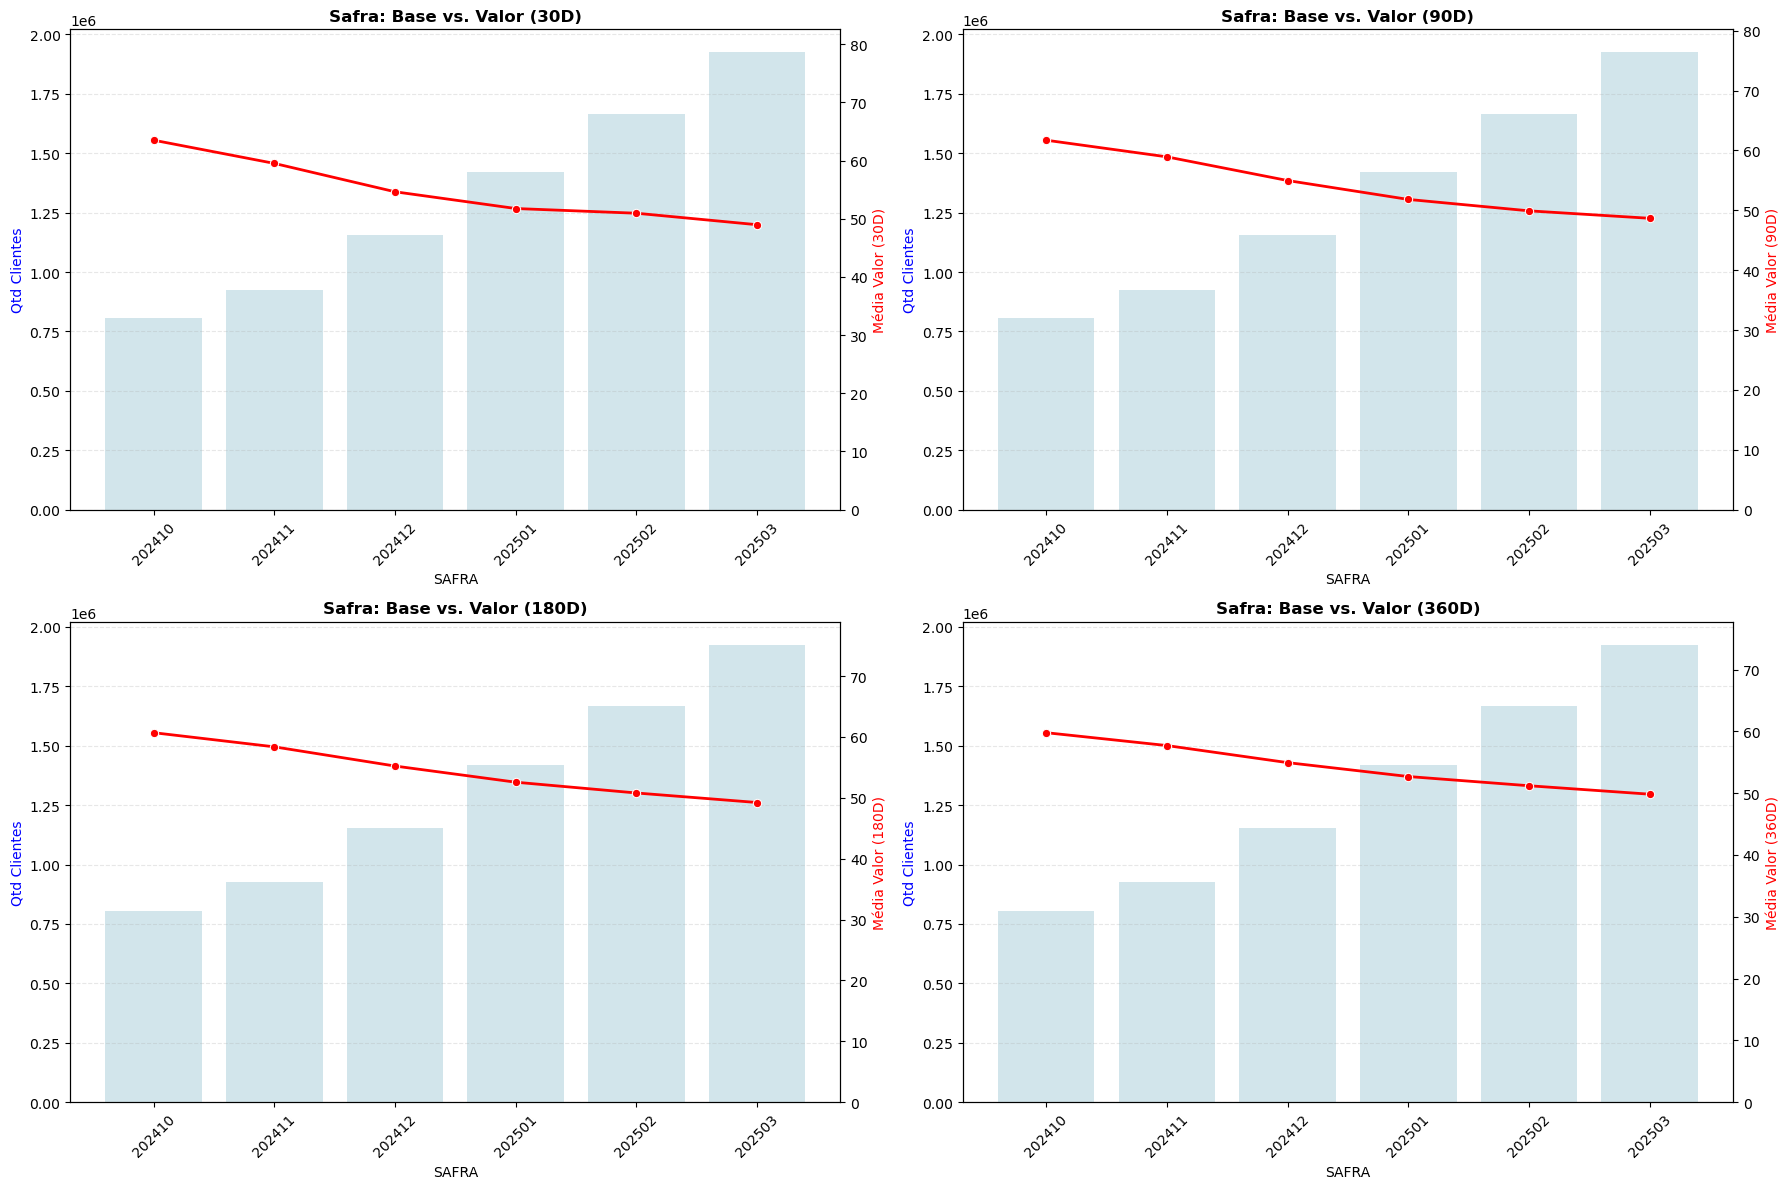

In [40]:
import math
import warnings

# Converta todas as colunas numéricas para Double antes do toPandas
cols_numericas = [c for c, t in resultado.dtypes if t.startswith('decimal') or t.startswith('long')]

for col_name in cols_numericas:
    resultado = resultado.withColumn(col_name, F.col(col_name).cast("double"))

# Convertendo para Pandas
pdf = resultado.toPandas()
janelas = ["30D", "90D", "180D", "360D"]

# Configurações da grade
n_cols = 2
n_rows = math.ceil(len(janelas) / n_cols)

# Criamos a figura principal
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

# --- BLOCO PARA SILENCIAR WARNINGS ---
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    for i, janela in enumerate(janelas):
        ax1 = axes[i]
        
        # 1. Gráfico de Barras
        sns.barplot(x='SAFRA', y='QTD_CLIENTES', data=pdf, ax=ax1, color='lightblue', alpha=0.6)
        ax1.set_ylabel('Qtd Clientes', color='blue', fontsize=10)
        ax1.set_ylim(bottom=0)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Eixo secundário
        ax2 = ax1.twinx()
        col_media = f"MEDIA_GLOBAL_{janela}"
        
        sns.lineplot(x=range(len(pdf['SAFRA'])), y=col_media, data=pdf, 
                     ax=ax2, color='red', marker='o', linewidth=2)
        
        # Ajuste de escala e erro de Decimal
        valor_maximo = float(pdf[col_media].max())
        ax2.set_ylabel(f'Média Valor ({janela})', color='red', fontsize=10)
        ax2.set_ylim(0, valor_maximo * 1.3)
        
        ax1.set_title(f'Safra: Base vs. Valor ({janela})', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Remove eixos vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **1. Dinâmica de Crescimento vs. Valor (Caudas de Safra)**

**- Correlação Inversa:** Existe uma clara correlação inversa entre o volume de clientes e o ticket médio.

**- Hipótese**: As safras mais recentes (202501 a 202503) podem estar operando com limites de crédito iniciais menores ou perfis de clientes mais "populares", o que justifica a média de valor menor em comparação à safra de 202410.

**- Ponto de Inflexão:** Entre 202411 e 202412, houve o maior salto no volume de clientes, que coincide com a inclinação mais acentuada de queda no valor médio.

### **2. Comparação entre Janelas (30D, 90D, 180D, 360D)**

**- Consistência Temporal:** As curvas de valor médio nas janelas de 90D, 180D e 360D são quase idênticas em inclinação. Isso sugere que o comportamento de gasto dos clientes é estabelecido logo no início e se mantém estável ao longo do tempo.

**- Sensibilidade do 30D:** A janela de 30D é a mais volátil. Se em algum mês futuro a linha de 30D cair abaixo da tendência das janelas maiores, você terá um indicador antecedente de perda de engajamento generalizada.


## Análise de Valor Total de Pagamentos por SAFRA

In [25]:
# Selecionando as SAFRAS e agrupando por VAL_PAGAMENTO_FATURA
safras = ["202410", "202411", "202412", "202501", "202502", "202503"]
df_valor_por_safra = (
    df_pagamentos.filter(F.col("SAFRA").isin(safras))
    .groupBy("SAFRA")
    .agg(
        F.sum("VAL_PAGAMENTO_FATURA").alias("VALOR_BRUTO_PAGAMENTOS")
    )
    .orderBy("SAFRA")
)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 27, Finished, Available, Finished)

StatementMeta(, d08000a5-258f-48d3-9d05-c7c5df9217d1, 28, Finished, Available, Finished)

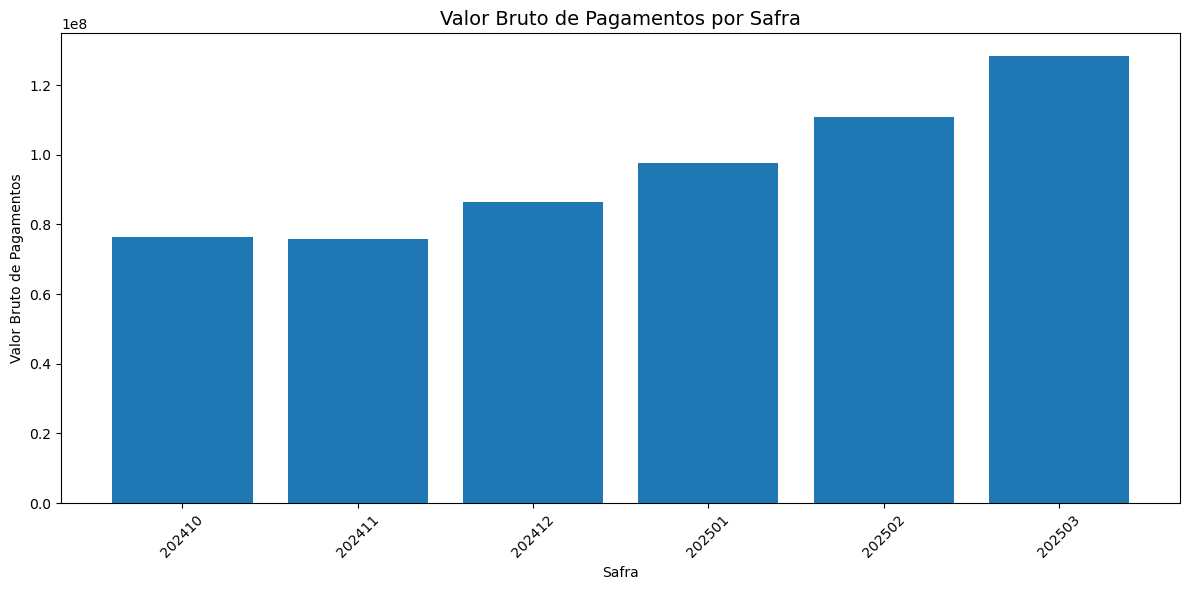

In [26]:
# Gerando o gráfico de barras
pdf_valor_safra = df_valor_por_safra.toPandas()

plt.figure(figsize=(12, 6))

plt.bar(
    pdf_valor_safra["SAFRA"],
    pdf_valor_safra["VALOR_BRUTO_PAGAMENTOS"]
)

plt.title("Valor Bruto de Pagamentos por Safra", fontsize=14)
plt.xlabel("Safra")
plt.ylabel("Valor Bruto de Pagamentos")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Observa-se uma tendência consistente de crescimento do valor bruto de pagamentos
ao longo das safras analisadas (202410 a 202503).

Esse crescimento ocorre de forma progressiva e está fortemente associado ao
aumento da base de clientes, conforme evidenciado pela elevação contínua da
quantidade de clientes por safra.

Em contrapartida, as médias de valor pago por cliente apresentam tendência de
queda ao longo do tempo, indicando que o crescimento do volume financeiro é
impulsionado principalmente pela expansão da base, e não pelo aumento do ticket
médio individual.

As safras mais recentes concentram o maior volume financeiro total, sugerindo
um cenário de crescimento sustentável do portfólio, com maior capilaridade de
clientes e manutenção da atividade transacional.

## Análise de Engajamento dos Clientes (30D x 360D)

In [26]:
# Normalização por Tempo para ter uma comparação justa entre 360D com 30D
df_freq_norm = df_ativos.select(
    "NUM_CPF",
    "SAFRA",
    (F.col("QT_PAG_360D") / 12).alias("PAG_MES_360"),
    (F.col("QT_PAG_180D") / 6).alias("PAG_MES_180"),
    (F.col("QT_PAG_90D") / 3).alias("PAG_MES_90"),
    F.col("QT_PAG_30D").alias("PAG_MES_30")
)

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 27, Finished, Available, Finished)

In [27]:
# Resultado normalização
df_freq_norm.show(truncate=False)

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 28, Finished, Available, Finished)

+-----------+------+------------------+------------------+------------------+----------+
|NUM_CPF    |SAFRA |PAG_MES_360       |PAG_MES_180       |PAG_MES_90        |PAG_MES_30|
+-----------+------+------------------+------------------+------------------+----------+
|7787TZY8787|202410|2.8333333333333335|1.5               |1.6666666666666667|3         |
|77Y8XXTYNZU|202410|1.5               |1.0               |1.0               |1         |
|77ZTWX7NNU9|202410|2.4166666666666665|1.8333333333333333|1.6666666666666667|3         |
|78NWUWWU87Y|202410|1.75              |0.6666666666666666|0.6666666666666666|0         |
|78U9ZWUZWXT|202410|1.4166666666666667|1.0               |1.3333333333333333|2         |
|78UN7YN8W87|202410|1.3333333333333333|0.6666666666666666|0.6666666666666666|0         |
|78XWNZWYT7Y|202410|2.4166666666666665|1.1666666666666667|1.0               |0         |
|7998YZYN887|202410|2.8333333333333335|2.0               |1.3333333333333333|2         |
|79ZNUU9W7XT|202410|1

In [28]:
# Calculando a Razão de Engajamento
# Ratio > 1.0: Cliente acelerando (usando mais que a média histórica)
# Ratio < 1.0: Cliente desacelerando (usando menos que a média histórica)
df_engajamento = df_freq_norm.withColumn(
    "RATIO_ENGAJAMENTO", 
    F.round(F.col("PAG_MES_30") / F.col("PAG_MES_360"), 2)
)

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 29, Finished, Available, Finished)

In [29]:
# Resultado df_engajamento
df_engajamento.select("NUM_CPF", "SAFRA", "PAG_MES_360", "PAG_MES_30", "RATIO_ENGAJAMENTO").show()

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 30, Finished, Available, Finished)

+-----------+------+------------------+----------+-----------------+
|    NUM_CPF| SAFRA|       PAG_MES_360|PAG_MES_30|RATIO_ENGAJAMENTO|
+-----------+------+------------------+----------+-----------------+
|7787TZY8787|202410|2.8333333333333335|         3|             1.06|
|77Y8XXTYNZU|202410|               1.5|         1|             0.67|
|77ZTWX7NNU9|202410|2.4166666666666665|         3|             1.24|
|78NWUWWU87Y|202410|              1.75|         0|              0.0|
|78U9ZWUZWXT|202410|1.4166666666666667|         2|             1.41|
|78UN7YN8W87|202410|1.3333333333333333|         0|              0.0|
|78XWNZWYT7Y|202410|2.4166666666666665|         0|              0.0|
|7998YZYN887|202410|2.8333333333333335|         2|             0.71|
|79ZNUU9W7XT|202410|1.4166666666666667|         1|             0.71|
|7N8ZZ8WZXZZ|202410| 4.666666666666667|         3|             0.64|
|7TUY89979XT|202410|1.4166666666666667|         1|             0.71|
|7U98NYZX7ZZ|202410|2.833333333333

In [42]:
df_engajamento.select(F.max("PAG_MES_30").alias("Valor_max_30")).show()

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 43, Finished, Available, Finished)

+------------+
|Valor_max_30|
+------------+
|          94|
+------------+



StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 31, Finished, Available, Finished)

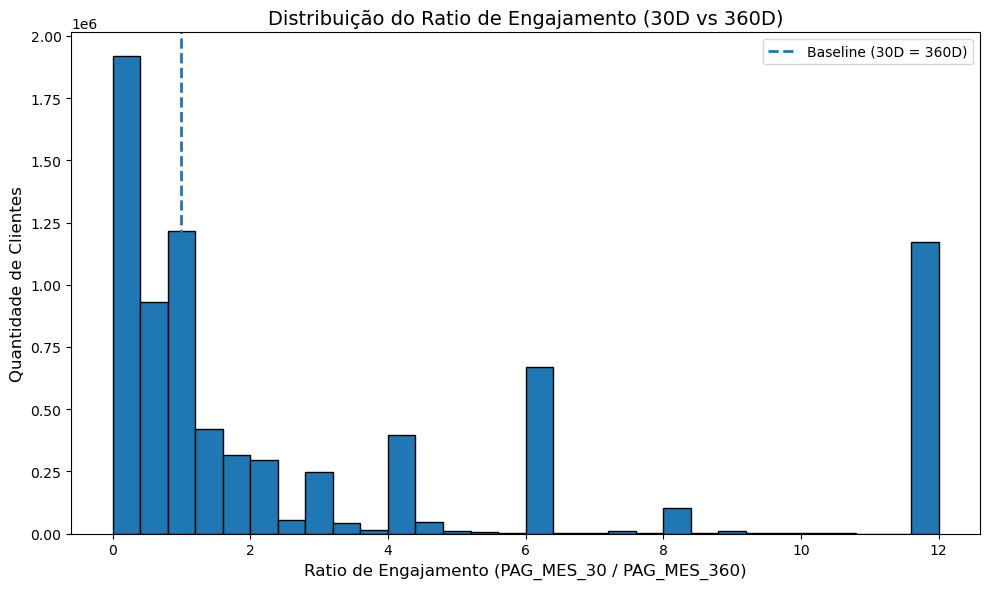

In [30]:
# Selecionar a base e convertendo para Pandas
df_plot = (
    df_engajamento
    .select("RATIO_ENGAJAMENTO")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(10, 6))

plt.hist(
    df_plot["RATIO_ENGAJAMENTO"],
    bins=30,
    edgecolor="black"
)

# Linha de referência em 1.0
plt.axvline(
    x=1.0,
    linestyle="--",
    linewidth=2,
    label="Baseline (30D = 360D)"
)

plt.title("Distribuição do Ratio de Engajamento (30D vs 360D)", fontsize=14)
plt.xlabel("Ratio de Engajamento (PAG_MES_30 / PAG_MES_360)", fontsize=12)
plt.ylabel("Quantidade de Clientes", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

StatementMeta(, 7f31d58a-c9b0-4c18-b7f1-6c5924601533, 39, Finished, Available, Finished)

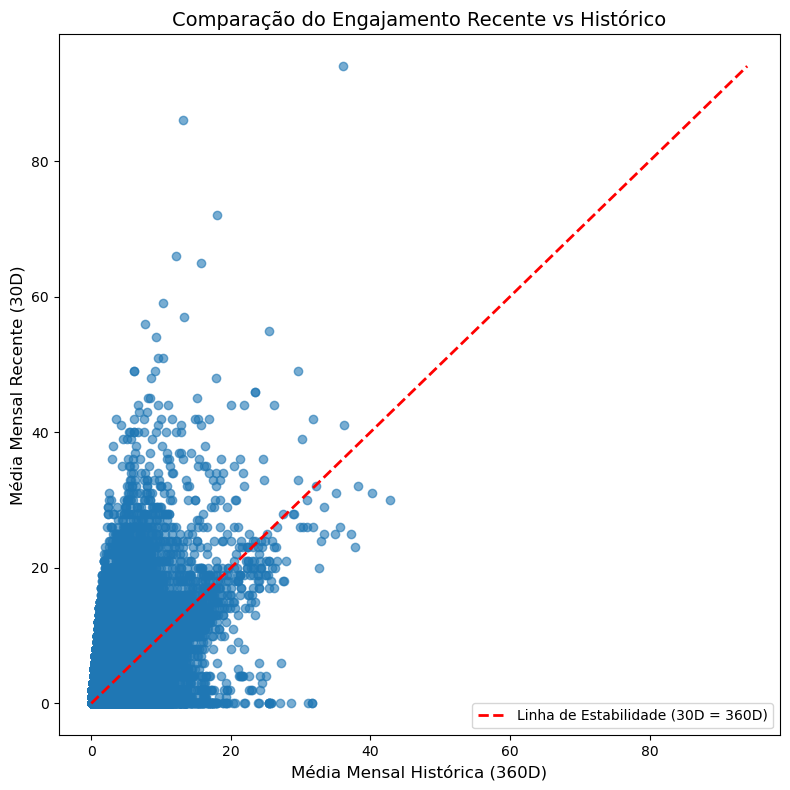

In [38]:
# Converter para pandas
df_scatter = (
    df_engajamento
    .select("PAG_MES_360", "PAG_MES_30")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(8, 8))

plt.scatter(
    df_scatter["PAG_MES_360"],
    df_scatter["PAG_MES_30"],
    alpha=0.6
)

# Linha y = x (baseline)
max_val = df_scatter[["PAG_MES_360", "PAG_MES_30"]].values.max()

plt.plot(
    [0, max_val],
    [0, max_val],
    linestyle="--",
    color='red',
    linewidth=2,
    label="Linha de Estabilidade (30D = 360D)"
)

plt.xlabel("Média Mensal Histórica (360D)", fontsize=12)
plt.ylabel("Média Mensal Recente (30D)", fontsize=12)
plt.title("Comparação do Engajamento Recente vs Histórico", fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Análise do Engajamento Recente vs Histórico

Com o objetivo de identificar mudanças no comportamento de pagamento dos clientes, foi construída uma métrica de **Ratio de Engajamento**, definida como a razão entre a média mensal de pagamentos dos últimos 30 dias e a média mensal histórica de 360 dias. Essa abordagem permite comparar o comportamento recente com o padrão histórico de forma normalizada pelo tempo.

### Distribuição do Ratio de Engajamento (Histograma)

O histograma do ratio de engajamento evidencia uma **distribuição assimétrica à direita**, com grande concentração de clientes apresentando valores **próximos ou abaixo de 1**, indicando manutenção ou redução do engajamento recente em relação ao histórico. Observa-se também a presença de uma **cauda longa à direita**, composta por um número reduzido de clientes com ratios elevados.

Esses valores extremos estão associados, em geral, a clientes com **baixo engajamento histórico** que apresentaram **picos pontuais de uso recente**, o que gera uma aceleração proporcional elevada, mas não necessariamente representa um aumento estrutural de volume.

### Comparação entre Engajamento Recente e Histórico (Scatterplot)

O gráfico de dispersão entre a média mensal histórica (360 dias) e a média mensal recente (30 dias) permite avaliar o comportamento individual dos clientes. Nota-se a presença relevante de pontos **acima da linha de estabilidade (y = x)**, indicando aceleração recente do engajamento para parte da base.

Entretanto, essa aceleração ocorre predominantemente entre clientes com **baixo histórico de uso**, enquanto clientes com maior engajamento histórico tendem a se concentrar próximos ou abaixo da linha de estabilidade, sugerindo manutenção ou desaceleração do comportamento recente.

### Presença de Outliers no Engajamento Recente

A análise do engajamento recente evidencia a existência de clientes com comportamento atípico nos últimos 30 dias. Observam-se casos extremos de clientes que realizaram **mais de 80 pagamentos em um período de 30 dias**, configurando outliers no eixo de engajamento recente.

Esses comportamentos impactam diretamente a distribuição do ratio de engajamento e contribuem para a cauda longa observada no histograma. Embora representem aceleração significativa em termos proporcionais, esses casos não necessariamente refletem aumento estrutural de engajamento financeiro, podendo estar associados a padrões operacionais específicos ou eventos pontuais.

Dessa forma, tais registros foram identificados no EDA como comportamentos atípicos e devem ser tratados com atenção em análises posteriores, seja por segmentação específica, limitação de valores extremos ou análise complementar de contexto.


### Principais Insights

- A aceleração recente de engajamento existe, mas está concentrada em clientes com baixo histórico, resultando em altos ratios sem aumento proporcional de volume absoluto.
- A maior parte da base mantém baixo engajamento ou apresenta desaceleração recente, indicando ausência de uma mudança estrutural de comportamento no conjunto dos clientes.
- A análise conjunta dos gráficos reforça que o ratio de engajamento captura variações reais de comportamento, mas deve ser interpretado em conjunto com métricas de volume histórico para avaliação de risco e elegibilidade à migração de planos.
